# Envouthe Churn Prediction

Envouthé souhaite réduire le % de churn et investir les efforts marketing sur les clients à risques (70% de risque de non renouvellement de l’abonnement) afin qu’ils renouvellent leur abonnement.

**Context**
- Les clients Envouthé peuvent souscrire à des abonnements mensuels, trimestriels, semestriels et annuels.
- A l’issue de la date de fin d’abonnement, le client doivent renouveler son abonnement.
- Dans le même lapse de temps, l'équipe marketing Envouthé envoie régulièrement un certain nombre d'emails promotionnels et d’emails d’informations.

**Objectif**
- Prédire le risque de churn pour les clients en fin d’abonnement

**Description du use case retenu:**
- En fonction du comportement des clients, l’algorithme va déduire un score de 0 à 1 (0 pas d'appétence au renouvellement ; 1 appétence au renouvellement forte)  
- si appétence > 0,7; pas d’action particulière
- si appétence entre 0,3 et 0,7 , c'est une visiteur tiède, le marketing pourra envoyer des offres marketing afin d’augmenter le % de renouvellement
- sinon: envoi d’une enquête satisfaction client

**Columns**
- id_subscriptionMain: id d'abonnement
- id_order: id de commande
- client_name: nom de client
- email: email de client
- box_name: nom de box
- subscriptions_type: type d'abonnement. Le numéro signifie que la durée de l’abonnement/la durée des échéances d’abonnement prévues dans le système. 
- month: la date du mois qui s'est écoulé depuis la date de début 	
- submain_state: le statut d'abonnement.
- product_attribute: l'attribut de produit	
- id: id de client
- last_name: nom de famille de client
- newsletter: si l'utilisateur inscrit le newsletter ou pas
- age: age de client
- ending_season: abonnement termine a quelle saison
- first_name: prenom de client
- abonnement_succ: si l'abonnement est active le mois suivant ou pas
- abonnement_consec: la durée de l'abonnement effectif par rapport a la date de début
- total_sub: nombre total d'abonnements
- ending_month: date de fin d'abonnement
- churn: si l'abonnement va renouveller ou pas

In [1]:
# change these to try this notebook out
BUCKET = 'test_envouthe'
PROJECT = 'envouthe-datalake'
REGION = 'europe-west1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import copy
import seaborn as sns
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report

print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [5]:
# Call BigQuery and examine in dataframe
import google.datalab.bigquery as bq

query = """
 SELECT
   *
 FROM
   renew_abonnement.merged_ds
"""

dataset = bq.Query(query).execute().result().to_dataframe()

dataset.head()

,int64_field_0,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,month,submain_state,product_attribute,...,last_name,newsletter,age,ending_season,first_name,abonnement_succ,abonnement_consec,total_sub,ending_month,churn___
0,4980,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-03-01,CANCELED,Durée de l'abonnement :illimité;Fréquence d'e...,...,alice,False,NaN,summer,milcent,True,1,1,2014-03-01,No
1,4981,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-04-01,CANCELED,Durée de l'abonnement :illimité;Fréquence d'e...,...,alice,False,NaN,summer,milcent,True,2,2,2014-03-01,No
2,4982,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-05-01,CANCELED,Durée de l'abonnement :illimité;Fréquence d'e...,...,alice,False,NaN,summer,milcent,True,3,3,2014-03-01,No
3,4983,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-06-01,CANCELED,Durée de l'abonnement :illimité;Fréquence d'e...,...,alice,False,NaN,summer,milcent,True,4,4,2014-03-01,No
4,6782,16396,5303,Adeline Roux,adeline_19@hotmail.fr,Abonnement mensuel,12,2013-03-01,CANCELED,Durée de l'abonnement :illimité;Fréquence d'e...,...,Adeline,False,NaN,autumn,Roux,True,1,1,2014-03-01,No


In [6]:
# supprimer le champ inutil
dataset = dataset.drop('int64_field_0', axis=1)
# modifier le nom de champ churn___ par churn
dataset = dataset.rename(columns={'churn___':'churn'})

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193586 entries, 0 to 193585
Data columns (total 20 columns):
id_subscriptionMain    193586 non-null int64
id_order               193586 non-null int64
client_name            193586 non-null object
email                  193586 non-null object
box_name               193586 non-null object
subscriptions_type     193586 non-null int64
month                  193586 non-null object
submain_state          193586 non-null object
product_attribute      193586 non-null object
id                     193586 non-null int64
last_name              193586 non-null object
newsletter             193586 non-null bool
age                    70335 non-null float64
ending_season          193586 non-null object
first_name             193586 non-null object
abonnement_succ        193585 non-null object
abonnement_consec      193586 non-null int64
total_sub              193586 non-null int64
ending_month           193586 non-null object
churn                  

In [8]:
dataset.isnull().sum()

id_subscriptionMain         0
id_order                    0
client_name                 0
email                       0
box_name                    0
subscriptions_type          0
month                       0
submain_state               0
product_attribute           0
id                          0
last_name                   0
newsletter                  0
age                    123251
ending_season               0
first_name                  0
abonnement_succ             1
abonnement_consec           0
total_sub                   0
ending_month                0
churn                       0
dtype: int64

- le champ age a perdu beaucoup de donnees
- les champ abonnement_succ a perdu 1 valeur.

In [9]:
dataset.nunique()

id_subscriptionMain    12004
id_order               12004
client_name             8532
email                   8588
box_name                   2
subscriptions_type        67
month                     92
submain_state              4
product_attribute          2
id                      8593
last_name               5390
newsletter                 2
age                       68
ending_season              4
first_name              5641
abonnement_succ            2
abonnement_consec        325
total_sub               1452
ending_month              81
churn                      4
dtype: int64

- on peut regarder le nombres de categories sur chaque champ.

## data exploration

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


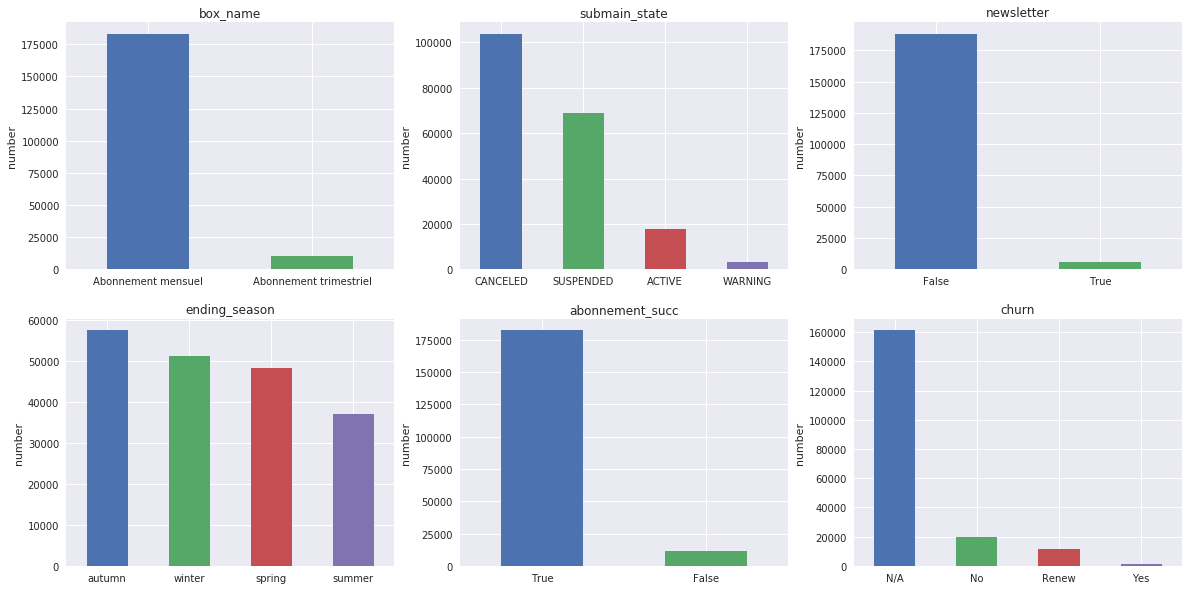

In [10]:
fig = plt.figure()
fig.set_size_inches(20, 10)

plt.subplot2grid((2,3),(0,0))
dataset.box_name.value_counts().plot(kind='bar')
plt.title(u"box_name")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.subplot2grid((2,3),(0,1))
dataset.submain_state.value_counts().plot(kind='bar')
plt.title(u"submain_state")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.subplot2grid((2,3),(0,2))
dataset.newsletter.value_counts().plot(kind='bar')
plt.title(u"newsletter")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.subplot2grid((2,3),(1,0))
dataset.ending_season.value_counts().plot(kind='bar')
plt.title(u"ending_season")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.subplot2grid((2,3),(1,1))
dataset.abonnement_succ.value_counts().plot(kind='bar')
plt.title(u"abonnement_succ")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.subplot2grid((2,3),(1,2))
dataset.churn.value_counts().plot(kind='bar')
plt.title(u"churn")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.show()

- la plupart sont l'abonnement mensuel
- beaucoup d'abonnements sont resilies et suspendus
- la plupart des clients n'acceptent pas de newsletter
- beaucoup d'abonnements vont terminer en Automne
- la plupart des abonnements sont actives dans le mois suivant

les valeurs de churn:

- N/A: les cas ambigus, si la date a dépassé le délai de l'abonnement mais il n'y a pas de succession
- No: si la date n'a pas dépassé le délai de l'abonnements et il y a une activité le mois suivant
- Renew: la date a dépassée le délai mais il y a une activité
- Yes: si la date n'a pas dépassée et il n'y a pas d'activité le mois suivant

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


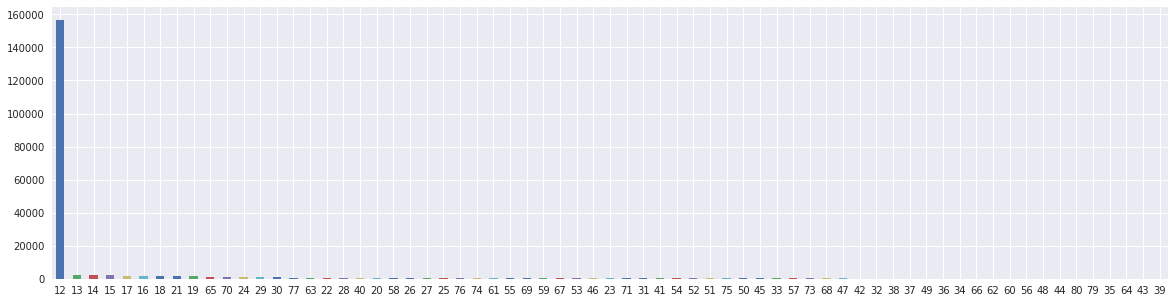

In [11]:
fig = plt.figure()
fig.set_size_inches(20,5)

dataset.subscriptions_type.value_counts().plot(kind='bar')
pl.xticks(rotation=360)
plt.show()

- la plupart sont le type 12.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


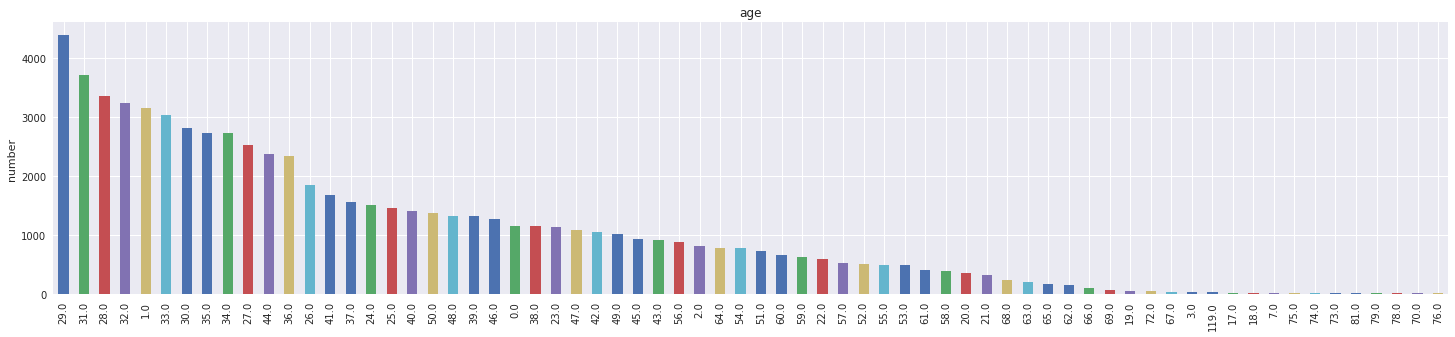

In [12]:
fig = plt.figure()
fig.set_size_inches(25, 5)

dataset.age.value_counts().plot(kind='bar')
plt.title(u"age")
plt.ylabel(u"number")

plt.show()

- la plupart des clients sont environ 30 ans.

In [13]:
dataset.describe()

,id_subscriptionMain,id_order,subscriptions_type,id,age,abonnement_consec,total_sub
count,193586.000000,193586.000000,193586.000000,193586.000000,70335.000000,193586.000000,193586.000000
mean,15344.674083,25376.650868,16.381071,15241.941091,34.700306,3.704421,65.637985
std,7609.259003,17693.468155,12.968175,13799.500174,14.128657,13.244771,130.961960
min,7.000000,2.000000,12.000000,1.000000,0.000000,1.000000,1.000000
25%,10091.000000,10760.000000,12.000000,4645.000000,28.000000,1.000000,7.000000
50%,15350.500000,20777.000000,12.000000,10152.000000,33.000000,1.000000,21.000000
75%,21396.000000,42879.000000,12.000000,22586.000000,44.000000,1.000000,68.000000
max,29677.000000,60194.000000,80.000000,47781.000000,119.000000,325.000000,1452.000000


## data preprocessing

In [14]:
df = copy.deepcopy(dataset)

# supprimer les champs
df = df.drop('product_attribute', axis = 1) # champ inutil
df = df.drop('first_name', axis = 1) # c'est le meme que le champ client_name
df = df.drop('last_name', axis = 1) # c'est le meme que le champ client_name

df.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,month,submain_state,id,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,ending_month,churn
0,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-03-01,CANCELED,5868,False,NaN,summer,True,1,1,2014-03-01,No
1,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-04-01,CANCELED,5868,False,NaN,summer,True,2,2,2014-03-01,No
2,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-05-01,CANCELED,5868,False,NaN,summer,True,3,3,2014-03-01,No
3,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,2013-06-01,CANCELED,5868,False,NaN,summer,True,4,4,2014-03-01,No
4,16396,5303,Adeline Roux,adeline_19@hotmail.fr,Abonnement mensuel,12,2013-03-01,CANCELED,5880,False,NaN,autumn,True,1,1,2014-03-01,No


In [15]:
# definir les donnees numeriques et les donnees categoriques
date_col = ['month', 'ending_month']
bool_col = ['newsletter', 'abonnement_succ']
numerique = ['subscriptions_type', 'age', 'abonnement_consec', 'total_sub']
categorique = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'id', 'id_order', 'month', 'ending_month', 'newsletter', 'abonnement_succ', \
                                            'subscriptions_type', 'age', 'abonnement_consec', 'total_sub']]

x_date = df[date_col]
x_bool = df[bool_col]
x_numerique = df[numerique]
x_categorique = df[categorique]

print(x_date.shape, x_bool.shape, x_numerique.shape, x_categorique.shape)

(193586, 2) (193586, 2) (193586, 4) (193586, 6)


**preprocessing sur les donnees date**

In [16]:
# verifier les valeurs nulles
print(x_date.isnull().sum())

month           0
ending_month    0
dtype: int64


In [17]:
df['month'] = pd.to_datetime(df['month'])
df['ending_month'] = pd.to_datetime(df['ending_month'])

# on ignore le jour, car c'est toujours le 1 du mois
df['Pyear'] = df['month'].dt.year
df['Pmonth'] = df['month'].dt.month

df['end_year'] = df['ending_month'].dt.year
df['end_month'] = df['ending_month'].dt.month

#supprimer les champs month et ending_month
df = df.drop(columns=['month','ending_month'])

df.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,submain_state,id,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,churn,Pyear,Pmonth,end_year,end_month
0,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,False,NaN,summer,True,1,1,No,2013,3,2014,3
1,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,False,NaN,summer,True,2,2,No,2013,4,2014,3
2,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,False,NaN,summer,True,3,3,No,2013,5,2014,3
3,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,False,NaN,summer,True,4,4,No,2013,6,2014,3
4,16396,5303,Adeline Roux,adeline_19@hotmail.fr,Abonnement mensuel,12,CANCELED,5880,False,NaN,autumn,True,1,1,No,2013,3,2014,3


**preprocessing sur les donnees boolean**

In [18]:
# verifier les valeurs nulles
print(x_bool.isnull().sum())

newsletter         0
abonnement_succ    1
dtype: int64


In [19]:
# on supprimer cette valeur nulle
df =df.dropna(subset=['abonnement_succ'],how='any')

df['newsletter'] = df['newsletter'].astype(float)
df['abonnement_succ'] = df['abonnement_succ'].astype(float)
df.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,submain_state,id,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,churn,Pyear,Pmonth,end_year,end_month
0,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,0.0,NaN,summer,1.0,1,1,No,2013,3,2014,3
1,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,0.0,NaN,summer,1.0,2,2,No,2013,4,2014,3
2,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,0.0,NaN,summer,1.0,3,3,No,2013,5,2014,3
3,16422,5288,alice milcent,a-force-de-vivre@hotmail.fr,Abonnement mensuel,12,CANCELED,5868,0.0,NaN,summer,1.0,4,4,No,2013,6,2014,3
4,16396,5303,Adeline Roux,adeline_19@hotmail.fr,Abonnement mensuel,12,CANCELED,5880,0.0,NaN,autumn,1.0,1,1,No,2013,3,2014,3


**preprocessing sur les donnees numeriques**

In [20]:
# verifier les valeurs nulles
print(x_numerique.isnull().sum())

subscriptions_type         0
age                   123251
abonnement_consec          0
total_sub                  0
dtype: int64


In [21]:
# on peut completer les valeurs nulles par median, mais il y a nombreux valeurs nulles sur le champ age, cela va prendre beaucoup de bruit
# sinon on prend en compte les valeurs nulles comme une type
# alors, on va transformer le champ age par deux valeurs: have age et not have age

# df.age = df.age.fillna(df.age.median())

df.loc[(df.age.notnull()), 'age'] = 1 # have age
df.loc[(df.age.isnull()), 'age'] = 0 # not have age

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


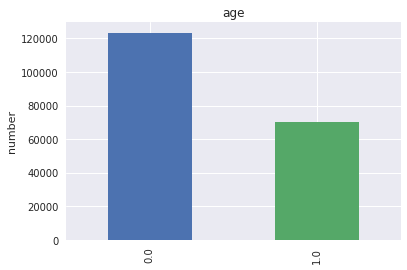

In [22]:
# visualiser
fig = plt.figure()

df.age.value_counts().plot(kind='bar')
plt.title(u"age")
plt.ylabel(u"number")

plt.show()

**preprocessing sur les champs categoriques**

In [23]:
# verifier les valeurs nulles
print(x_categorique.isnull().sum())

client_name      0
email            0
box_name         0
submain_state    0
ending_season    0
churn            0
dtype: int64


In [24]:
# supprimer les champs qui ont trop de categoriques et ils n'affectent pas sur le churn
df = df.drop(columns=['client_name','email'])

# convertir les valeurs categorique en valeurs numeriques
# box_name
df['box_name'] = df['box_name'].replace(['Abonnement mensuel','Abonnement trimestriel'],[0,1])

# # submain_state
df['submain_state'] = df['submain_state'].replace(['CANCELED','SUSPENDED','ACTIVE','WARNING'],[0,1,2,3])

# # ending_season
df['ending_season'] = df['ending_season'].replace(['spring','summer','autumn','winter'],[0,1,2,3])

# # churn
df['churn'] = df['churn'].replace(['No','Yes','Renew','N/A'],[0,1,2,3])

df.head()

,id_subscriptionMain,id_order,box_name,subscriptions_type,submain_state,id,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,churn,Pyear,Pmonth,end_year,end_month
0,16422,5288,0,12,0,5868,0.0,0.0,1,1.0,1,1,0,2013,3,2014,3
1,16422,5288,0,12,0,5868,0.0,0.0,1,1.0,2,2,0,2013,4,2014,3
2,16422,5288,0,12,0,5868,0.0,0.0,1,1.0,3,3,0,2013,5,2014,3
3,16422,5288,0,12,0,5868,0.0,0.0,1,1.0,4,4,0,2013,6,2014,3
4,16396,5303,0,12,0,5880,0.0,0.0,2,1.0,1,1,0,2013,3,2014,3


In [25]:
# definir les features et le label
ids = ['id_subscriptionMain', 'id', 'id_order']
label = ['churn']

features = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'id', 'id_order', 'churn']]
data = [j for j in df.columns.values.tolist() if j not in ['id_subscriptionMain', 'id', 'id_order']]

df_id = df[ids] # id_subscriptionMain, id_order et id
df_data = df[data] # features + label
df_features = df[features] # tous les champs sauf ids et churn
df_label = df[label] # churn

In [26]:
df_id.shape, df_data.shape, df_features.shape, df_label.shape

((193585, 3), (193585, 14), (193585, 13), (193585, 1))

In [27]:
# normalisation
df_features = minmax_scale(df_features, axis = 0)
df_features = pd.DataFrame(df_features, columns=features)

# concat df_features and df_label

df_data = pd.concat([df_features,df_label], axis = 1)
df = pd.concat([df_id, df_data], axis = 1)

df.head()

,id_subscriptionMain,id,id_order,box_name,subscriptions_type,submain_state,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,Pyear,Pmonth,end_year,end_month,churn
0,16422.0,5868.0,5288.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.000000,0.000000,0.125,0.181818,0.142857,0.181818,0.0
1,16422.0,5868.0,5288.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.003086,0.000689,0.125,0.272727,0.142857,0.181818,0.0
2,16422.0,5868.0,5288.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.006173,0.001378,0.125,0.363636,0.142857,0.181818,0.0
3,16422.0,5868.0,5288.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.009259,0.002068,0.125,0.454545,0.142857,0.181818,0.0
4,16396.0,5880.0,5303.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,0.000000,0.000000,0.125,0.181818,0.142857,0.181818,0.0


In [28]:
print(df.shape)
df.isnull().sum()

(193586, 17)


id_subscriptionMain    1
id                     1
id_order               1
box_name               1
subscriptions_type     1
submain_state          1
newsletter             1
age                    1
ending_season          1
abonnement_succ        1
abonnement_consec      1
total_sub              1
Pyear                  1
Pmonth                 1
end_year               1
end_month              1
churn                  1
dtype: int64

In [29]:
df = df.dropna(how='any')
print(df.shape)

(193584, 17)


In [30]:
df['churn'] = df['churn'].astype(int)
df['id_subscriptionMain'] = df['id_subscriptionMain'].astype(int)
df['id'] = df['id'].astype(int)
df['id_order'] = df['id_order'].astype(int)

df.head()

,id_subscriptionMain,id,id_order,box_name,subscriptions_type,submain_state,newsletter,age,ending_season,abonnement_succ,abonnement_consec,total_sub,Pyear,Pmonth,end_year,end_month,churn
0,16422,5868,5288,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.000000,0.000000,0.125,0.181818,0.142857,0.181818,0
1,16422,5868,5288,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.003086,0.000689,0.125,0.272727,0.142857,0.181818,0
2,16422,5868,5288,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.006173,0.001378,0.125,0.363636,0.142857,0.181818,0
3,16422,5868,5288,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.009259,0.002068,0.125,0.454545,0.142857,0.181818,0
4,16396,5880,5303,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,0.000000,0.000000,0.125,0.181818,0.142857,0.181818,0


**heat map pour la correlation**

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


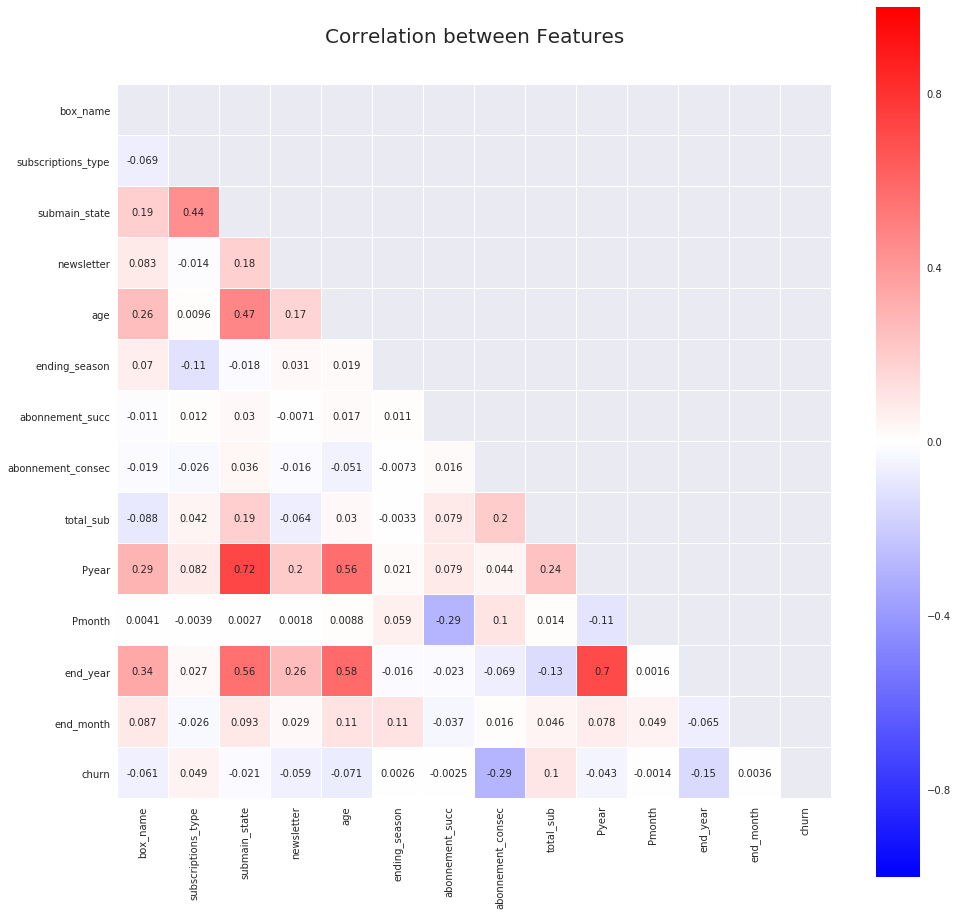

In [31]:
# Heat map pour la correlation entre les features
colormap = plt.cm.bwr
# colormap.set_size
plt.figure(figsize=(16,16))
plt.title('Correlation between Features', y=1.05, size = 20)

# Generate a mask for the upper triangle
corr = df_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# heatmap
sns.heatmap(df_data.corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True,
           mask = mask)

plt.show()

- en fonction de la matrice de correlation, on trouve que les champs abonnement_consec et end_year sont les plus negativement correles; le champs total_sub est le plus positivement correle.

## machine learning

**splitting data**

dataset original est trop grand pour le test, on reduit donc la taille de donnees

In [33]:
# echantilloner au hasard 10% des données
print(df.shape)
df = df.sample(frac=0.1, random_state=123, axis=0)

print(df.shape)

(193584, 17)
(19358, 17)


In [34]:
# choisir les 3 features les plus correles en fonction de matrice de correlation.

train_data = ['id_subscriptionMain','abonnement_consec', 'end_year', 'total_sub','churn'] 
train_features = ['abonnement_consec', 'end_year', 'total_sub']

df = df[train_data]
df_features = df[train_features]

df.head()

,id_subscriptionMain,abonnement_consec,end_year,total_sub,churn
163938,20666,0.000000,0.428571,0.540317,3
193175,26997,0.000000,0.857143,0.006203,3
7151,1165,0.009259,0.571429,0.042040,2
143371,11820,0.000000,0.142857,0.026189,3
2458,16494,0.000000,0.142857,0.022743,3


In [35]:
train,test = train_test_split(df,test_size = .3 ,random_state = 123)

test_id_sub = test['id_subscriptionMain'].astype(int)
# test_id_ord = test['id_order'].astype(int)
# test_id_cust = test['id'].astype(int)

cols = [i for i in df_features.columns.values.tolist()]
train_X = train[cols]
train_Y = train['churn']
test_X  = test[cols]
test_Y  = test['churn']


**logistic regression**

In [36]:
# Logistic Regression classifier
LR = LogisticRegression()
LR.fit(train_X, train_Y)

# prediction

# 2 prediction type
y_pred_lr = LR.predict(test_X) 
# y_pred_prob_lr = LR.predict_proba(test_X) # Predict probabilities

In [37]:
# visualisation le resultat de prediction
result_lr = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), 'churn':y_pred_lr.astype(np.int32)})
result_lr.head()

,churn,id_subscriptionMain
0,3,18574
1,3,9960
2,3,15098
3,3,16268
4,3,13944


In [38]:
# y_pred_prob_lr_0 = y_pred_prob_lr[:,0]
# y_pred_prob_lr_1 = y_pred_prob_lr[:,1]
# y_pred_prob_lr_2 = y_pred_prob_lr[:,2]
# y_pred_prob_lr_3 = y_pred_prob_lr[:,3]

# result_prob_lr = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), \
#                                'churn_0':y_pred_prob_lr_0, 'churn_1':y_pred_prob_lr_1,\
#                               'churn_2':y_pred_prob_lr_2, 'churn_3':y_pred_prob_lr_3})
# result_prob_lr.head()

In [39]:
# evaluation

# accuracy_score
LR_accuracy = accuracy_score(test_Y,y_pred_lr)
print ("LR Accuracy score = {}".format(LR_accuracy))

LR Accuracy score = 0.8536501377410468


**Decision Tree**

In [41]:
# decision tree classifier

# DT = DecisionTreeClassifier(random_state=40,max_depth=3)
DT = DecisionTreeClassifier(random_state=111)

DT.fit(train_X, train_Y)

# prediction

y_pred_dt = DT.predict(test_X)
y_pred_prob_dt = DT.predict_proba(test_X)

In [42]:
result_dt = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), 'churn':y_pred_dt.astype(np.int32)})
result_dt.head()

,churn,id_subscriptionMain
0,3,18574
1,3,9960
2,3,15098
3,3,16268
4,3,13944


In [43]:
# y_pred_prob_dt_0 = y_pred_prob_dt[:,0]
# y_pred_prob_dt_1 = y_pred_prob_dt[:,1]
# y_pred_prob_dt_2 = y_pred_prob_dt[:,2]
# y_pred_prob_dt_3 = y_pred_prob_dt[:,3]

# result_prob_dt = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), \
#                                'churn_0':y_pred_prob_dt_0, 'churn_1':y_pred_prob_dt_1,\
#                               'churn_2':y_pred_prob_dt_2, 'churn_3':y_pred_prob_dt_3})
# result_prob_dt.head()

In [44]:
# evaluation

# accuracy score
DT_accuracy = accuracy_score(test_Y,y_pred_dt)
print ("DT Accuracy score = {}".format(DT_accuracy))

DT Accuracy score = 0.962465564738292


**Random Forest**

In [46]:
# random forest classifier

RF = RandomForestClassifier(random_state=111)
RF.fit(train_X, train_Y)

# prediction

y_pred_rf = RF.predict(test_X)
y_pred_prob_rf = RF.predict_proba(test_X)

In [47]:
result_rf = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), 'churn':y_pred_rf.astype(np.int32)})
result_rf.head()

,churn,id_subscriptionMain
0,3,18574
1,3,9960
2,3,15098
3,3,16268
4,3,13944


In [48]:
# y_pred_prob_rf_0 = y_pred_prob_rf[:,0]
# y_pred_prob_rf_1 = y_pred_prob_rf[:,1]
# y_pred_prob_rf_2 = y_pred_prob_rf[:,2]
# y_pred_prob_rf_3 = y_pred_prob_rf[:,3]

# result_prob_rf = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), \
#                                'churn_0':y_pred_prob_rf_0, 'churn_1':y_pred_prob_rf_1,\
#                               'churn_2':y_pred_prob_rf_2, 'churn_3':y_pred_prob_rf_3})
# result_prob_rf.head()

In [49]:
# evaluation

# accuracy_score
RF_accuracy = accuracy_score(test_Y,y_pred_rf)
print ("RF Accuracy score = {}".format(RF_accuracy))

RF Accuracy score = 0.9674586776859504


**Neural network**

In [51]:
#Create feature columns for estimator
def make_feature_cols():
    input_columns = [tf.feature_column.numeric_column(k) for k in train_features]
    return input_columns

#Train, eval and predict input functions to read from Pandas Dataframe
def train_func(train_x,train_y):
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
    dataset = dataset.shuffle(1000).repeat().batch(100)
    return dataset

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
 
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

In [52]:
import shutil

OUTDIR = 'envouthe_algo'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
tf.logging.set_verbosity(tf.logging.INFO)

# DNN classifier with tf.Estimator framework

model = tf.estimator.DNNClassifier(
    model_dir = OUTDIR,
    feature_columns=make_feature_cols(),
    hidden_units=[64, 32], # specify hidden layers
    n_classes=4 # classify the output classes
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_evaluation_master': '', '_master': '', '_task_id': 0, '_service': None, '_model_dir': 'envouthe_algo', '_num_worker_replicas': 1, '_session_config': None, '_is_chief': True, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_train_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa986f14400>, '_tf_random_seed': None}


In [53]:
# train

model.train(
    input_fn=lambda:train_func(train_X,train_Y),
    steps=1000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into envouthe_algo/model.ckpt.
INFO:tensorflow:step = 1, loss = 140.73895
INFO:tensorflow:global_step/sec: 499.252
INFO:tensorflow:step = 101, loss = 41.011837 (0.206 sec)
INFO:tensorflow:global_step/sec: 722.292
INFO:tensorflow:step = 201, loss = 14.10059 (0.139 sec)
INFO:tensorflow:global_step/sec: 759.037
INFO:tensorflow:step = 301, loss = 30.722855 (0.132 sec)
INFO:tensorflow:global_step/sec: 768.809
INFO:tensorflow:step = 401, loss = 32.79554 (0.130 sec)
INFO:tensorflow:global_step/sec: 702.682
INFO:tensorflow:step = 501, loss = 31.810755 (0.142 sec)
INFO:tensorflow:global_step/sec: 750.664
INFO:tensorflow:step = 601, loss = 23.526974 (0.133 sec)
INFO:tensorflow:global_step/sec: 761.193
INFO:tensorflow:step 

In [54]:
# prediction

y_pred_dnn = model.predict(
        input_fn=lambda:eval_input_fn(test_X,labels=None,batch_size=100))

In [55]:
predict_arr = []
# y_pred_prob_dnn_0 = []
# y_pred_prob_dnn_1 = []
# y_pred_prob_dnn_2 = []
# y_pred_prob_dnn_3 = []

for predict in y_pred_dnn:
    predict_arr.append(predict['probabilities'].argmax())
#     y_pred_prob_dnn_0.append(predict['probabilities'][0])
#     y_pred_prob_dnn_1.append(predict['probabilities'][1])
#     y_pred_prob_dnn_2.append(predict['probabilities'][2])
#     y_pred_prob_dnn_3.append(predict['probabilities'][3])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from envouthe_algo/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [56]:
result_dnn = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), 'churn':predict_arr})
result_dnn.head()

,churn,id_subscriptionMain
0,3,18574
1,3,9960
2,3,15098
3,3,16268
4,3,13944


In [57]:
# result_prob_dnn = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), \
#                                'churn_0':y_pred_prob_dnn_0, 'churn_1':y_pred_prob_dnn_1,\
#                               'churn_2':y_pred_prob_dnn_2, 'churn_3':y_pred_prob_dnn_3})
# result_prob_dnn.head()

In [58]:
# evaluation

test_Y = np.array(test_Y).reshape(len(test_Y),1)
predict_arr = np.array(predict_arr).reshape(len(predict_arr),1)

n_batches = len(test_Y)

# accuracy score
graph = tf.Graph()
with graph.as_default():
    # Placeholders to take in batches of data
    tf_label = tf.placeholder(dtype=tf.int32, shape=[None])
    tf_prediction = tf.placeholder(dtype=tf.int32, shape=[None])
    # Define the metric and update operations
    accuracy_dnn, accuracy_dnn_update = tf.metrics.accuracy(tf_label,
                               tf_prediction,
                               name='accuracy_dnn')
    # Isolate the variables stored behind the scenes by the metric operation
    running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="accuracy_dnn")
    # Define initializer to initialize/reset running variables
    running_vars_initializer = tf.variables_initializer(var_list=running_vars)
    
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    # initialize/reset the running variables
    session.run(running_vars_initializer)
    for i in range(n_batches):
        # Update the running variables on new batch of samples
        feed_dict={tf_label: test_Y[i], tf_prediction: predict_arr[i]}
        session.run(accuracy_dnn_update, feed_dict=feed_dict)
        
    # Calculate the score
    DNN_accuracy = session.run(accuracy_dnn)
    print ("Dnn Accuracy score = {}".format(DNN_accuracy))

Dnn Accuracy score = 0.9438705444335938


**SVM**

In [60]:
# C-Support Vector Classification

svc = SVC(probability=True)
svc.fit(train_X, train_Y)

# prediction

y_pred_svc = svc.predict(test_X)
# y_pred_prob_svc = svc.predict_proba(test_X)

In [61]:
# visualisation le resultat de prediction

result_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), 'churn':y_pred_svc.astype(np.int32)})
result_svc.head()

,churn,id_subscriptionMain
0,3,18574
1,3,9960
2,3,15098
3,3,16268
4,3,13944


In [62]:
# y_pred_prob_svc_0 = y_pred_prob_svc[:,0]
# y_pred_prob_svc_1 = y_pred_prob_svc[:,1]
# y_pred_prob_svc_2 = y_pred_prob_svc[:,2]
# y_pred_prob_svc_3 = y_pred_prob_svc[:,3]

# result_prob_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.as_matrix(), \
#                                'churn_0':y_pred_prob_svc_0, 'churn_1':y_pred_prob_svc_1,\
#                               'churn_2':y_pred_prob_svc_2, 'churn_3':y_pred_prob_svc_3})
# result_prob_svc.head()

In [63]:
# evaluation

# accuracy_score
SVM_accuracy = accuracy_score(test_Y,y_pred_svc)
print ("SVM Accuracy score = {}".format(SVM_accuracy))

SVM Accuracy score = 0.8657024793388429


## comparaison

In [65]:
# Predictive_models = pd.DataFrame({
#     'Model': ['Logistic Regression', 'Decison Tree', 'Random Forest', 'Neural Network' ],
#     'Score_accuracy': [LR_accuracy, DT_accuracy, RF_accuracy, DNN_accuracy]})

Predictive_models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decison Tree', 'Random Forest', 'Neural Network', 'SVM' ],
    'Score_accuracy': [LR_accuracy, DT_accuracy, RF_accuracy, DNN_accuracy, SVM_accuracy]})

Predictive_models.sort_values(by ='Score_accuracy', ascending=False)

,Model,Score_accuracy
2,Random Forest,0.967459
1,Decison Tree,0.962466
3,Neural Network,0.943871
4,SVM,0.865702
0,Logistic Regression,0.853650


- en fonction de la comparaison de score accuracy, on va choisir l'algorithme qui a la meilleure note.